# Lab 2 

In [45]:
import numpy as np
import random, math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from IPython.display import Image, display


## Generate Test Data

In [46]:
def generate_data(classA_centers, classB_center, \
                  std=0.4, classA_size=10, classB_size=20, seed=100):
    np.random.seed(seed)
    random.seed(seed)
    
    # Generate class A data
    classA_data = []
    for center in classA_centers:
        cluster = np.random.randn(classA_size, 2) * std + center
        classA_data.append(cluster)
    classA = np.concatenate(classA_data)
    
    # Generate class B data  
    classB = np.random.randn(classB_size, 2) * std + classB_center
    
    # Combine and shuffle
    inputs = np.concatenate((classA, classB))
    targets = np.concatenate((
        np.ones(classA.shape[0]),
        -np.ones(classB.shape[0])
    ))
    
    N = inputs.shape[0]
    perm = list(range(N))
    random.shuffle(perm)
    inputs, targets = inputs[perm, :], targets[perm]
    
    return inputs, targets, classA, classB, N, std
# Default
inputs, targets, classA, classB, N, std = generate_data([[1.5, 0.5], [-1.5, 0.5]], [0.0, -0.5])

# Hard separation - move classes closer together  
# inputs, targets, classA, classB, N, std = generate_data([[0.8, 0.2], [-0.8, 0.2]], [0.0, -0.2])

# Overlapping - same centers, bigger std
# inputs, targets, classA, classB, N, std = generate_data([[1.0, 0.5], [-1.0, 0.5]], [0.0, -0.5], std=0.5)

# Different sizes - make class A smaller
# inputs, targets, classA, classB, N, std = generate_data([[1.5, 0.5], [-1.5, 1.5]], [0.0, -0.5], classA_size=15, classB_size=30)

## Plotting

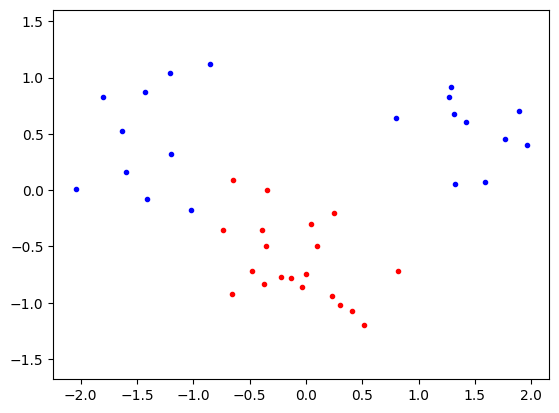

In [47]:
plt.plot([p[0] for p in classA], [p[1] for p in classA], 'b.')
plt.plot([p[0] for p in classB], [p[1] for p in classB], 'r.')
plt.axis('equal')
# plt.savefig('svmplot.pdf') # Save a copy in a file
plt.show()

## Kernal Functions & Choose a kernel

In [48]:
def linear_kernel(x, y):
    return np.dot(x, y)

def poly_kernel(x, y, p=2):
    return (np.dot(x, y) + 1.0)**p

def rbf_kernel(x, y, sigma=3):
    # The parameter is used to control the smoothness of the boundary
    diff = x - y
    return np.exp(-np.dot(diff, diff) / (2*sigma**2))

kernel = linear_kernel 

## Pre-process

In [49]:
# For efficiency, pre-compute the matrix 
P = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        P[i, j] = targets[i] * targets[j] * kernel(inputs[i], inputs[j])

In [50]:
# Define the objective function (Equation 4) and the equality constraint function (Equation 10)
def objective(alphas):
    return 0.5 * np.dot(alphas, np.dot(P, alphas)) - np.sum(alphas)

def zerofun(alphas):
    return np.dot(alphas, targets)

## Solve the optimization problem

In [51]:
# Slack parameter
C = 1  # Scalar for soft margin
# C = None # None for hard margin
start_alphas = np.zeros(N)
# To have an upper constraint
bounds = [(0, C) for b in range(N)]


In [52]:
constraints = {'type': 'eq', 'fun': zerofun}

ret = minimize(objective, start_alphas, bounds=bounds, constraints=constraints)
alphas = ret['x']
success = ret['success']
# The string 'success' instead holds a boolean representing if the optimizer has found a solution
if (not success): 
    raise ValueError(f'Cannot find optimizing solution when std is {std} and C is {C}')
print(f"Optimization successful: {success} when std is {std} and C is {C}")

Optimization successful: True when std is 0.4 and C is 1


In [53]:
# A small threshold for floating-point values
threshold = 1e-5
support_vectors_indices = np.where(alphas > threshold)[0]

# Save support vectors
nonzero_inputs = inputs[support_vectors_indices]
nonzero_targets = targets[support_vectors_indices]
nonzero_alphas = alphas[support_vectors_indices]
nonzero = [(alphas[i], inputs[i], targets[i]) for i in range(N) if abs(alphas[i]) > 10e-5]
# Calculate b using a support vector (Eq. 7)
b = 0
for i in range(len(nonzero_alphas)):
    # Find a support vector with alpha < C for robust calculation
    if C is None or nonzero_alphas[i] < C:
        b = np.sum(nonzero_alphas * nonzero_targets * np.array([kernel(nonzero_inputs[i], sv) for sv in nonzero_inputs])) - nonzero_targets[i]
        break

print(f"Number of support vectors: {len(nonzero_inputs)}")
print(f"Value of b: {b}")

Number of support vectors: 16
Value of b: -0.17563440037233513


In [54]:
def indicator(s):
    # s should be a single 2D point (e.g., a numpy array of shape (2,))
    total = 0
    for i in range(len(nonzero_alphas)):
        total += nonzero_alphas[i] * nonzero_targets[i] * kernel(s, nonzero_inputs[i])
    return total - b

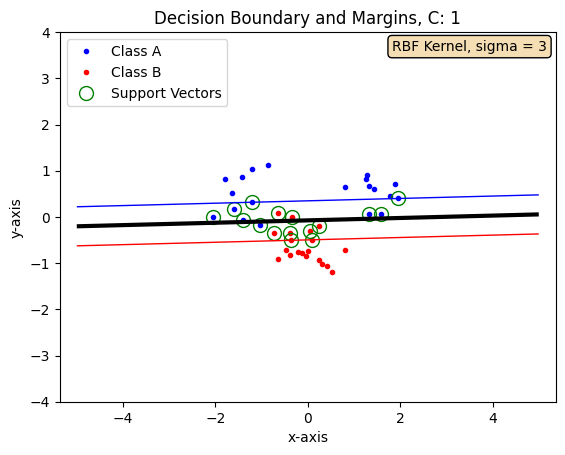

In [55]:
# Plot contour
xgrid = np.linspace(-5, 5)
ygrid = np.linspace(-4, 4)
grid = np.array([[indicator(np.array([x, y])) for x in xgrid] for y in ygrid])

# Plot the data points again
plt.plot([p[0] for p in classA], [p[1] for p in classA], 'b.', label='Class A')
plt.plot([p[0] for p in classB], [p[1] for p in classB], 'r.', label='Class B')
plt.axis('equal')

# Highlight support vectors
plt.plot([p[0] for p in nonzero_inputs], [p[1] for p in nonzero_inputs], 'go',
         label='Support Vectors', markersize=10, fillstyle='none')

# Plot the decision boundary and margins
plt.contour(xgrid, ygrid, grid, (-1.0, 0.0, 1.0),
            colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))
plt.legend()
plt.title(f"Decision Boundary and Margins, C: {C}")
# plt.text(0.8,0.95, 'Linear Kernel', 
#          transform=plt.gca().transAxes, 
#          bbox=dict(boxstyle='round', facecolor='wheat'))
# plt.text(0.72,0.95, 'Poly Kernel, p = 2', 
        #  transform=plt.gca().transAxes, 
        #  bbox=dict(boxstyle='round', facecolor='wheat'))
plt.text(0.67,0.95, 'RBF Kernel, sigma = 3', 
         transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='wheat'))
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.savefig('poly.pdf') # Save a copy in a file
plt.show()
